In [53]:
from torchsearchsorted import searchsorted
import numpy as np
#from scipy.stats import wasserstein_distance
import seaborn as sns
from matplotlib import pyplot as plt
import torch

# set up test nn
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else: device = torch.device('cpu')
    
test_nn = torch.nn.Sequential(
    torch.nn.Linear(1,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,225)
).to(device)


real_eigs_cody = np.loadtxt("ppo2/h11=15.txt")
real_eigs_cody = torch.Tensor(real_eigs_cody).to(device)

def _cdf_distance(p, u_values, v_values):
    #print "input", u_values, v_values
    u_sorter = torch.argsort(u_values).to(device)
    v_sorter = torch.argsort(v_values).to(device)

    all_values = torch.cat((u_values, v_values))
    all_values, _ = all_values.sort()
    #print'av',all_values

    # Compute the differences between pairs of successive values of u and v.
    deltas = all_values[1:] - all_values[:-1]  # replaces call to np.diff
    u_cdf_indices = searchsorted(torch.tensor([list([u_values[u_sorter]][0])]), torch.tensor([list([all_values[:-1]][0])])).to(device)
    v_cdf_indices = searchsorted(torch.tensor([list([v_values[v_sorter]][0])]), torch.tensor([list([all_values[:-1]][0])])).to(device)
    #print 'ucdfind', u_cdf_indices

    # Calculate the CDFs of u and v using their weights, if specified.
    u_cdf = u_cdf_indices / u_values.shape[0]
    v_cdf = v_cdf_indices / v_values.shape[0]

    #print 'uv', u_cdf, v_cdf

    #print 'check1', deltas

    return torch.sum(torch.abs(u_cdf-v_cdf)*deltas)
    return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
    return torch.pow(torch.sum(torch.pow(torch.abs(u_cdf - v_cdf), p) * deltas), 1 / p)


def wasserstein_distance(u, v):
    return _cdf_distance(1, u, v)

def AAtranspose(A): # computes AAtrans for a matrix A
    return torch.mm(A,torch.transpose(A,0,1))

def random_matrix(nn=test_nn): # pos def metric
    mat = nn(torch.rand(1).to(device)).reshape(15,15)
    return AAtranspose(mat)

def sample(numdraws,nn=test_nn):
    evals = torch.tensor([]).to(device)
    for num in range(numdraws):
        evals = torch.cat((evals,torch.symeig(random_matrix(nn=nn),eigenvectors=True)[0]))
    return evals


In [54]:
h11s = [10,30,50]
numdraws = [10,20,30,40,50]
data = {'h11': [], 'evals': [], 'numdraws': []}

num_samples_per = 1
for h11 in h11s:
    for numdraw in numdraws:
        evals = torch.tensor([]).to(device)
        for _ in range(num_samples_per): 
            evals = torch.cat((evals,sample(numdraw)))
        for e in evals:
            data['h11'].append(h11)
            data['numdraws'].append(numdraw)
            data['evals'].append(float(e.cpu().detach().numpy()))
            
import pandas as pd
df = pd.DataFrame(data)

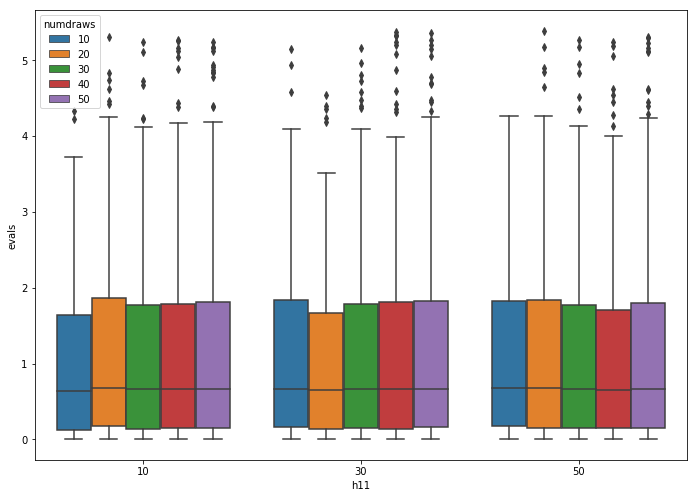

In [55]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

with torch.no_grad():
    sns.boxplot(x='h11',y='evals',hue='numdraws',data=df)

# Wasserstein Sample Efficiency

10
20
30
40
50
10
20
30
40
50
10
20
30
40
50


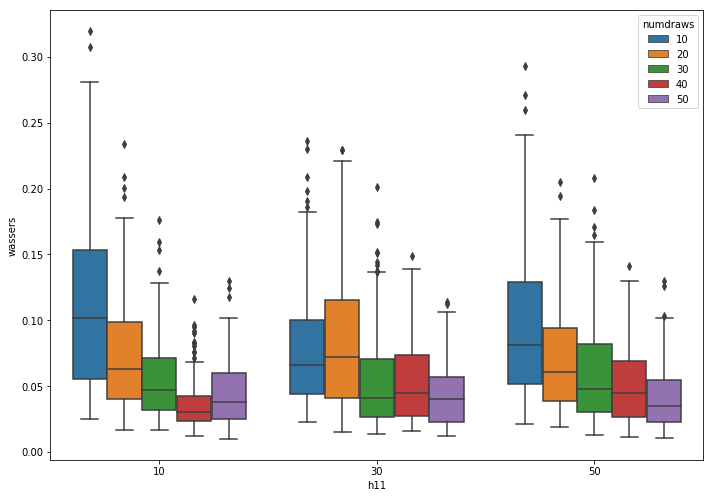

In [58]:
#from scipy.stats import wasserstein_distance

h11s = [10,30,50]
numdraws = [10,20,30,40,50]
data = {'h11': [], 'wassers': [], 'numdraws': []}

num_samples_per = 20
for h11 in h11s:
    for numdraw in numdraws:
        print numdraw
        evals = [sample(numdraw) for _ in range(num_samples_per)]
        wassers = [wasserstein_distance(evals[i1],evals[i2]) for i1 in range(num_samples_per) for i2 in range(i1+1,num_samples_per)]
        for wasser in wassers:
             data['h11'].append(h11)
             data['numdraws'].append(numdraw)
             data['wassers'].append(float(wasser.cpu().detach().numpy()))
            
import pandas as pd
df = pd.DataFrame(data)
rcParams['figure.figsize'] = 11.7,8.27

sns.boxplot(x='h11',y='wassers',hue='numdraws',data=df)

In [42]:
from scipy.stats import wasserstein_distance

h11s = [10,30,50]
numdraws = [10,20,30,40,50,100]
data = {'h11': [], 'wassers': [], 'numdraws': []}

num_samples_per = 50
for h11 in h11s:
    for numdraw in numdraws:
        evals = [sample(h11,numdraw) for _ in range(num_samples_per)]
        wassers = [wasserstein_distance(evals[i1],evals[i2]) for i1 in range(num_samples_per) for i2 in range(i1+1,num_samples_per)]
        for wasser in wassers:
            data['h11'].append(h11)
            data['numdraws'].append(numdraw)
            data['wassers'].append(wasser)
            
import pandas as pd
df = pd.DataFrame(data)
rcParams['figure.figsize'] = 11.7,8.27

sns.boxplot(x='h11',y='wassers',hue='numdraws',data=df)

TypeError: 'int' object is not callable

# Dumb sanity check

In [79]:
num = 1000000
a, b = [np.random.normal(.5,.1) for _ in range(num)], [np.random.normal(.6,.1) for _ in range(num)]

print(wasserstein_distance(a,b))

0.09987389105968958
